In [2]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import sys 
import seaborn as sns
sys.path.append("/home/bruce1996/data/Yi-Fung-Chuang/")
sys.path.append("/home/bruce1996/data/Yi-Fung-Chuang/GMHI/")
from GMHI import GMHI,ocgmhi_plot
from microbiome_preprocessing import merge_emu_output,taxa_prevalence

## Dr Ho cohort

In [3]:
emu_output_path = "/home/bruce1996/data/Yi-Fung-Chuang/dr_ho/emu_output/"
ab_df = merge_emu_output(emu_output_path)
ab_df.index = ab_df['species']

In [7]:
health_prevent = pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/GMHI/gmhi_health_prevent_species.txt",header=None)
health_scarce = pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/GMHI/gmhi_health_scarce_species.txt",header=None)
health_prevent.columns = ['Species']
health_scarce.columns = ['Species']
probiotics = pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/GMHI/probiotics.txt")
pathogen = pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/GMHI/pathogen.txt")


In [8]:
#gmhi health-related species + custom health-associated species
health_sp = list(health_prevent['Species'].values) + list(probiotics['Species'].values)
health_sp = list(set(health_sp))
nohealth_sp = list(health_scarce['Species'].values) + list(pathogen['Species'].values)
nohealth_sp = list(set(nohealth_sp))
#gmhi only
health_sp = list(set(health_prevent['Species'].values))
nohealth_sp = list(set(health_scarce['Species'].values))

In [9]:
#intersection of ab_df & health/nohealth species
species = ab_df['species']
health_species = [x in health_sp for x in species]
nohealth_species = [x in nohealth_sp for x in species]
#subset ab_df
mh_df = ab_df.loc[health_species,:]
mh_df = mh_df.drop('species',axis = 1)
mn_df = ab_df.loc[nohealth_species,:]
mn_df = mn_df.drop('species',axis = 1)
#health-related species prevalence
health_pre = taxa_prevalence(mh_df)
nohealth_pre = taxa_prevalence(mn_df)
prevalence = health_pre + nohealth_pre

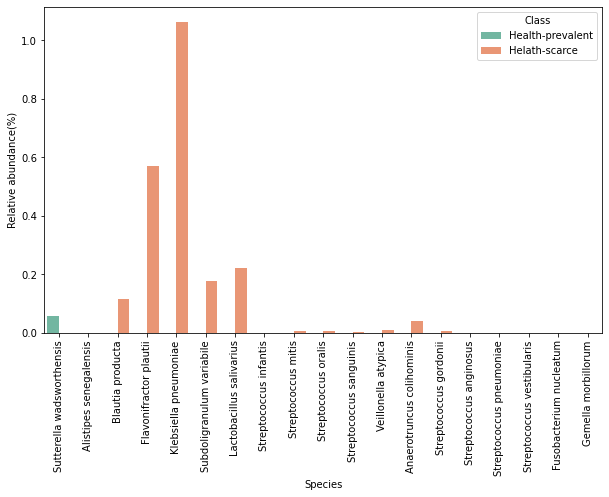

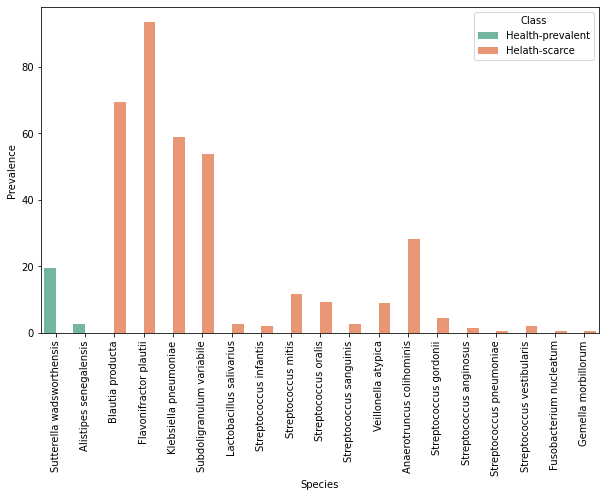

In [27]:
target_species_df = mh_df.append(mn_df)
mean_abundance = target_species_df.mean(axis = 1) * 100
idx = list(target_species_df.index)
label = ['Health-prevalent'] * mh_df.shape[0] + ['Helath-scarce'] * mn_df.shape[0]
tmp = {'Species' : idx,'Abundance' : mean_abundance,'Prevalence' : prevalence,'Class' :label}
df = pd.DataFrame(tmp)

#relative abundance of target species
output_path = '/home/bruce1996/data/Yi-Fung-Chuang/GMHI/tmp/'
dir_exist = os.path.exists(output_path)
if not dir_exist :
    os.makedirs(output_path)
plt.figure(figsize=(10, 6))
sns.barplot(x="Species", y="Abundance",hue='Class' ,data=df, palette="Set2")
plt.ylabel('Relative abundance(%)')
plt.xticks(rotation=90)
plt.savefig(output_path + 'Target_species_abundance_gmhi_only.png',dpi = 300,bbox_inches="tight")
#Prevalence of target species
plt.figure(figsize=(10, 6))
sns.barplot(x="Species", y="Prevalence",hue='Class' ,data=df, palette="Set2")
plt.xticks(rotation=90)
plt.savefig(output_path + 'Target_species_prevalence_gmhi_only.png',dpi = 300,bbox_inches="tight")

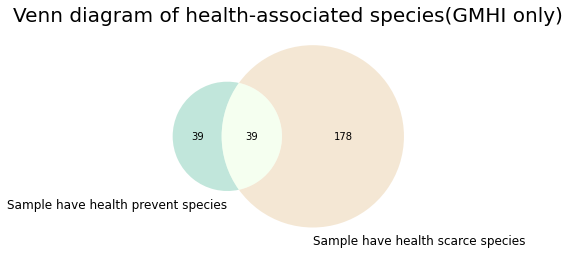

In [28]:
from matplotlib_venn import venn2
from mycolorpy import colorlist as mcp

colors=mcp.gen_color(cmap="Set2",n=10)
health_idx = mh_df.mean() > 0 
nohealth_idx = mn_df.mean() > 0
health_sample = set(mh_df.columns[health_idx])
nohealth_sample = set(mn_df.columns[nohealth_idx])

union = len(health_sample.intersection(nohealth_sample))
subset = (len(health_sample),len(nohealth_sample),union)
venn2(subsets=subset,set_labels=["Sample have health prevent species","Sample have health scarce species"],
set_colors=[colors[0], colors[-3]])
output_path = '/home/bruce1996/data/Yi-Fung-Chuang/GMHI/tmp/'
plt.title('Venn diagram of health-associated species(GMHI only)',fontsize = 20)
plt.savefig(output_path+'Venn_diagram_of_health-associated_species_gmhi_only.png',dpi = 300)
plt.show()

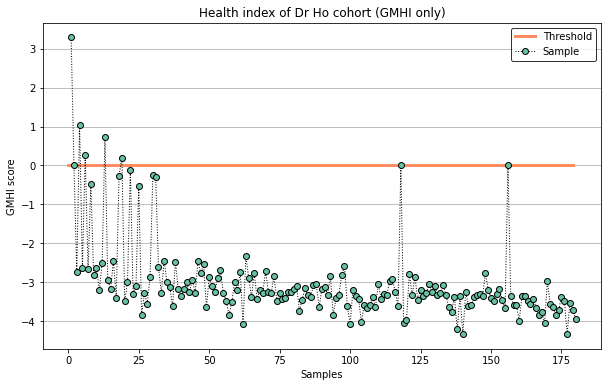

In [10]:
otu_tab = ab_df.drop('species',axis=1)
health_idx = [x in health_sp for x in ab_df['species']]
nohealth_idx = [x in nohealth_sp for x in ab_df['species']]
health_index,_,_ = GMHI(otu_tab,[],[],[],target_species=True,health_species=health_idx,nohealth_species=nohealth_idx)
#
output_path = '/home/bruce1996/data/Yi-Fung-Chuang/GMHI/tmp/'
ocgmhi_plot(0,health_index,'Sample',output_path +'/gmhi_score_of_dr_ho_gmhi_only.png','Health index of Dr Ho cohort (GMHI only)',ylabel='GMHI score')
#ocgmhi_plot(0,health_ab_diff,'Sample',output_path +'/abundance_diff_of_dr_ho.png','Health-associated species abundance difference of Dr Ho cohort')

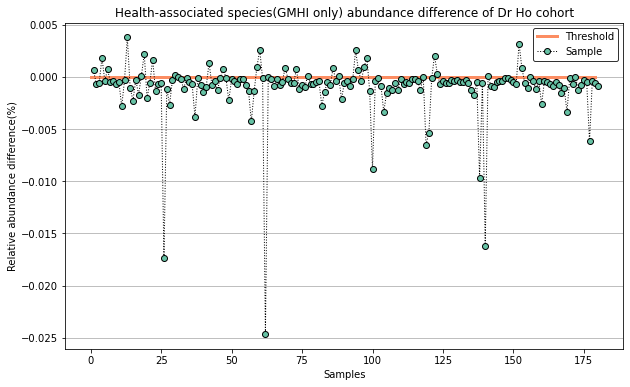

In [30]:
health_ab = mh_df.mean()
nohealth_ab = mn_df.mean()
health_ab_diff = list(health_ab - nohealth_ab)
ocgmhi_plot(0,health_ab_diff,'Sample',output_path +'/abundance_diff_of_dr_ho_gmhi_only.png',
'Health-associated species(GMHI only) abundance difference of Dr Ho cohort',ylabel= "Relative abundance difference(%)")

In [11]:
from numpy import log as ln
from sklearn.preprocessing import StandardScaler


def calculate_gmhi_score(otu_table,mh,mn,standardization = False) :
    '''
    otu_table : {n_taxa,n_sample} abundance table of tax 
    mh : list of health prevent species
    mn : list of health scarce species
    '''

    #calculate richness of mh / mn 
    mh_array = otu_table.loc[mh,:].to_numpy()
    mn_array = otu_table.loc[mn,:].to_numpy()
    if standardization == True :
        scaler_h = StandardScaler()
        mh_array = scaler_h.fit_transform(mh_array.T).T
        scaler_n = StandardScaler()
        mn_array = scaler_n.fit_transform(mn_array.T).T


    rmh = list()
    rmn = list()
    for i in range(otu_table.shape[1]):
        richness_h = np.mean(mh_array[:,i] > 0) * mh_df.shape[0]
        richness_n = np.mean(mn_array[:,i] > 0) * mn_df.shape[0]    
        rmh.append(richness_h)
        rmn.append(richness_n)
        
    rmh = sorted(rmh,reverse = True)
    rmn = sorted(rmn)

    k = round(otu_table.shape[1] * 0.01)
    
    rmhk = np.median(rmh[0:k])
    rmnk = np.median(rmn[-k:])
     
    gmhi = list()
    for i in range(otu_table.shape[1]) :
        ab_h = 0
        ab_n = 0
        for h in range(mh_array.shape[0]) :
            ab = mh_array[h,i]
            if ab > 0 :
                ab_h += ab*ln(ab)  
        for n in range(mn_array.shape[0]) :
            ab = mn_array[n,i]
            if ab > 0 :
                ab_n += ab * ln(ab)
                    
        score_h = abs((rmh[i]/rmhk) * ab_h) + 10 ** -5
        score_n = abs((rmn[i]/rmnk) * ab_n) + 10 ** -5

        gmhi.append(np.log10(score_h/score_n) )  

    return gmhi

In [12]:
otu_tab = ab_df.drop('species',axis=1)
health_idx = [x in health_sp for x in ab_df['species']]
nohealth_idx = [x in nohealth_sp for x in ab_df['species']]
gmhi_z_score = calculate_gmhi_score(otu_tab,mh=health_idx,mn = nohealth_idx,standardization=True)

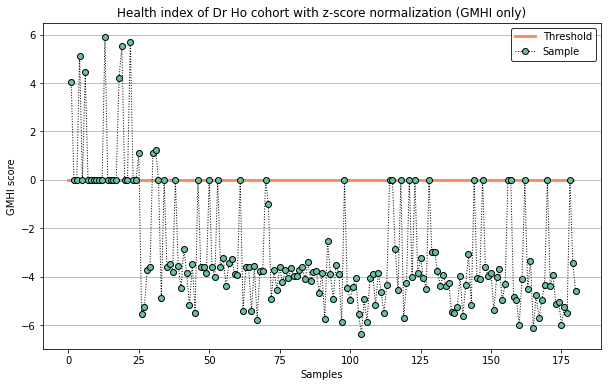

In [9]:
output_path = '/home/bruce1996/data/Yi-Fung-Chuang/GMHI/tmp/'
ocgmhi_plot(0,gmhi_z_score,'Sample',output_path +'/gmhi_score_of_dr_ho_z_score_normalization_gmhi_only.png','Health index of Dr Ho cohort with z-score normalization (GMHI only)',ylabel='GMHI score')
#ocgmhi_plot(0,health_ab_diff,'Sample',output_path +'/abundance_diff_of_dr_ho.png','Health-associated species abundance difference of Dr Ho cohort')

In [48]:
gmhi_df = pd.DataFrame({'Sample' : otu_tab.columns,'GMHI' : gmhi_z_score})
gmhi_df.index = gmhi_df['Sample']

### linear regression with health questionnaire

In [60]:
health_q_path = '/home/bruce1996/data/Yi-Fung-Chuang/health_questionaire.csv'
health_q = pd.read_csv(health_q_path)
#remove timestamp
#health_q = health_q.iloc[:,2:]
#remove column of barcode
health_q.index = health_q['代碼']
health_q = health_q.iloc[:,1:]

In [61]:
#find the missing data
sample = list(set(gmhi_df['Sample']).intersection(health_q.index))
missing = list(set(health_q.index) - set(sample))
missing_df = health_q.loc[missing,:]
missing_df.to_csv('/home/bruce1996/data/Yi-Fung-Chuang/health_questionaire_missing.csv')

sample_only_id = list(set(gmhi_df['Sample'].values) - set(sample))
sample_only_df = pd.DataFrame({'Sample_only' : sample_only_id})
sample_only_df.to_csv('/home/bruce1996/data/Yi-Fung-Chuang/sample_only_id.csv')

In [28]:
#remove duplicate sample
sample = list(set(gmhi_df['Sample']).intersection(health_q.index))
health_q = health_q.loc[sample,:]
rm_idx = health_q.loc[sample,:].index.duplicated()
rm_sample = set(health_q.loc[rm_idx,:].index)
unique_sample = set(sample) - rm_sample
idx = [x in unique_sample for x in health_q.index]
health_q = health_q.loc[idx,:]
idx = [x in unique_sample for x in gmhi_df.index]
gmhi_df_subset = gmhi_df.loc[idx,:]

In [103]:
health_q = health_q.drop(['身高','體重'],axis = 1)
gmhi_subset = gmhi_df_subset['GMHI']

In [116]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [107]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(health_q)
encoder.categories_
one_hot_matrix = encoder.transform(health_q).toarray()

In [133]:
x = one_hot_matrix
y = gmhi_subset.values
linear_r = LinearRegression().fit(x, y)
y_pred = linear_r.predict(x)

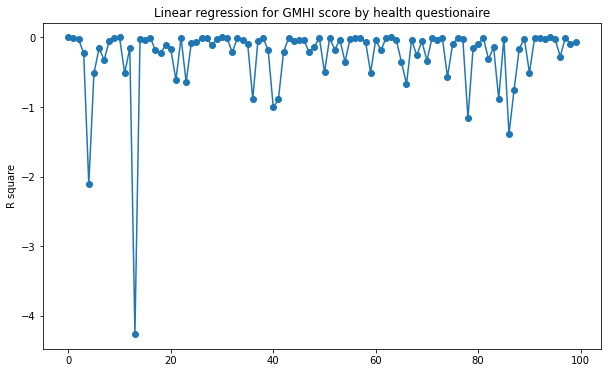

'\nplt.figure(figsize=(12,10))\nplt.scatter(y_pred,y_true,color = \'orange\')\nline = np.linspace(min_x,max_x)\nplt.plot(line,line)\nplt.annotate("r-squared = {:.3f}".format(r2),(min_x,max_x),fontsize = 15)\nplt.xlabel(\'Predict value\')\nplt.ylabel(\'True value\')\nplt.show()\n'

In [140]:
r2_list = []
for i in range(100) :
    model = LinearRegression(fit_intercept=True)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    y_true = y_test
    #y_true = bmi_info['BMI'].values
    max_x = max(y_pred.max(),y_true.max())
    min_x = min(y_pred.min(),y_true.min())
    r2_list.append(r2_score(y_pred,y_true))

xx = np.arange(100)
plt.figure(figsize=(10,6))
plt.errorbar(x = xx ,y=r2_list,fmt = 'o-')
plt.ylabel('R square')
plt.title('Linear regression for GMHI score by health questionaire')
plt.savefig(output_path + 'linear_regression_for_gmhi_by_health_questionaire_r2.png',dpi = 300)
plt.show()   
'''
plt.figure(figsize=(12,10))
plt.scatter(y_pred,y_true,color = 'orange')
line = np.linspace(min_x,max_x)
plt.plot(line,line)
plt.annotate("r-squared = {:.3f}".format(r2),(min_x,max_x),fontsize = 15)
plt.xlabel('Predict value')
plt.ylabel('True value')
plt.show()
'''
